# 04 - Architecture Investigation

In section 4, we take a DNN with SGD as the optimiser (as in section 3), and investigate the effects of changing the network architecture on the performance and convergence characteristics of the classifier. This section is split into multiple notebooks, to avoid running into memory issues by training too many neural networks at once. Much of the code for this section is adapted from Mohammed's code in section 3.

The number of epochs (30) and the batch size (500) are chosen to be the same as in section 3. We also use the same set of learning rates, although special attention is paid to the case $\varepsilon = 0.1$ as this was the best-performing case in section 3.

# 04.1 - Depth Investigation

The first subsection of the architecture investigation focuses on varying the depth of the network (by which I mean the number of *hidden* layers), while keeping the width constant (each layer always has 10 nodes in this subsection). We consider five cases:

* Zero depth (a perceptron)
* 1 hidden layer (a shallow neural network)
* 3 hidden layers
* 10 hidden layers
* 100 hidden layers

The first things we do are to import all the necessary libraries and functions, load and process our dataset, and set up functions to create our neural networks. There will be no further commentary here on these - the code here is identical to that in section 3.

In [1]:
import time
import json

import random as python_random
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.metrics import TruePositives
from tensorflow.keras.metrics import KLDivergence

from mlxtend.plotting import plot_confusion_matrix

#for reproducibility, we set random seeds here
#Jupyter can sometimes assign seed value only in the cell that the random seed is called
#you can change this rseed value so the entire notebook changes seed values
rseed = 42

np.random.seed(rseed)
python_random.seed(rseed)
tf.random.set_seed(rseed)

In [2]:
#load the dataframes created in the Data.ipynb section
X_train = pd.read_csv('..\data\X_train.csv')
X_val = pd.read_csv('..\data\X_val.csv')
X_test = pd.read_csv('..\data\X_test.csv')

y_train_bin = pd.read_csv('..\data\y_train_bin.csv')
y_val_bin = pd.read_csv('..\data\y_val_bin.csv')
y_test_bin = pd.read_csv('..\data\y_test_bin.csv')

y_train_multi = pd.read_csv('..\data\y_train_multi.csv')
y_val_multi = pd.read_csv('..\data\y_val_multi.csv')
y_test_multi = pd.read_csv('..\data\y_test_multi.csv')

In [3]:
#turn string labels into float categories, categs is list of categories
y_train_multi, categs = pd.factorize(y_train_multi.connection_category)
y_val_multi, categs = pd.factorize(y_val_multi.connection_category)
y_test_multi, categs = pd.factorize(y_test_multi.connection_category)
#turn float categories into tf.keras matrix categories of dimension length(categs)
#e.g. 'normal' = [1,0,0,0,0]
y_train_multi = to_categorical(y_train_multi, num_classes = len(categs))
y_val_multi = to_categorical(y_val_multi, num_classes = len(categs))
y_test_multi = to_categorical(y_test_multi, num_classes = len(categs))

In [4]:
def binaryDNN(train_df = X_train, hidden_nodes = [10,10,10], op = 'adam', metrics = [tf.keras.metrics.AUC()]):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers 
    for i in hidden_nodes:
        #we use 'relu' as good, safe default for our neural nets
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(1, activation = 'sigmoid'))
    
    #compile model
    nn_model.compile(loss='binary_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

 

def multiDNN(train_df = X_train, num_classes = 5, hidden_nodes = [10,10,10], op = 'adam', 
             c_metrics = ['accuracy',TruePositives(),tfa.metrics.CohenKappa(num_classes=5)]):
    
    '''
    Function that takes dataframe train_df and creates a multiclass classifer neural network 
    with softmax output layers equal to the number of classes passed
    
    train_df = dataframe or array 
    num_classes = int, number of classes in the dataset
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final 
                   output layer containing num_classes softmax nodes
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    c_metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    #we initiate our model differently here, taking layers as a list
    #this is because of some issues when implementing when creating a neural net as above
    layers = []
    #input dimensions
    layers.append(Input(shape = (train_df.shape[1],)))
    
    #add layers with dropout
    for i in hidden_nodes:
        layers.append(Dense(i, activation = 'relu'))
        layers.append(Dropout(0.2))
        
    #output layer with number of nodes = num_classes
    layers.append(Dense(num_classes, activation = 'softmax'))
    
    nn_model = Sequential(layers)
    #compile model
    nn_model.compile(loss='categorical_crossentropy',optimizer=op,metrics=c_metrics)
    
    return nn_model

Now that we have performed all of our setup, we setup and train all of our neural networks. Warning: this code block may take quite a while to run (in particular, the last iteration with 100 layers may take upwards of 5 minutes to train each model).

In [5]:
tf.random.set_seed(rseed)

count = 1
epochs = 30
batch_size = 500

x1 = -np.arange(1,5)
epsilons = np.float_power(10,x1)

layers = [0, 1, 3, 10, 100]

bin_models = []
bin_history = []
categ_models = []
categ_history = []

i = 0
for layercount in layers:

    nodes = [10]*layercount
    
    bin_models.append([])
    bin_history.append([])
    categ_models.append([])
    categ_history.append([])
    
    j = 0
    for eps in epsilons:

        optimizer = tf.keras.optimizers.SGD(learning_rate = eps, nesterov = False)
  
        bin_model_temp = binaryDNN(op = optimizer, hidden_nodes=nodes)
    
        print('-'*10 + 'Fitting binary model to sgd optimizer with learning rate {} and {} layers'.format(eps,layercount) + '-'*10)
        start = time.time()
        bin_history_temp = bin_model_temp.fit(X_train, y_train_bin, shuffle = True, validation_data = (X_val, y_val_bin), epochs = epochs, batch_size = batch_size, verbose = 0)
        end = time.time()
        print('Time taken: {} seconds'.format(end - start))

        bin_models[i].append(bin_model_temp)
        bin_history[i].append(bin_history_temp)

        categ_model_temp = multiDNN(op = optimizer, hidden_nodes=nodes)
        print('-'*10 + 'Fitting categorical model to sgd optimizer with learning rate {} and {} layers'.format(eps,layercount) + '-'*10)
        start = time.time()
        categ_history_temp = categ_model_temp.fit(X_train, y_train_multi, shuffle = True, validation_data = (X_val, y_val_multi), epochs = epochs, batch_size = batch_size, verbose = 0)
        end = time.time()
        print('Time taken: {} seconds'.format(end - start))

        categ_models[i].append(categ_model_temp)
        categ_history[i].append(categ_history_temp)

        #delete temp model and history to free up memory
        del bin_model_temp
        del bin_history_temp
        del categ_model_temp
        del categ_history_temp
        print()

        j += 1
        
    i += 1

----------Fitting binary model to sgd optimizer with learning rate 0.1 and 0 layers----------
Time taken: 52.03184247016907 seconds
----------Fitting categorical model to sgd optimizer with learning rate 0.1 and 0 layers----------
Time taken: 91.57658433914185 seconds

----------Fitting binary model to sgd optimizer with learning rate 0.01 and 0 layers----------
Time taken: 52.33244442939758 seconds
----------Fitting categorical model to sgd optimizer with learning rate 0.01 and 0 layers----------
Time taken: 98.71448111534119 seconds

----------Fitting binary model to sgd optimizer with learning rate 0.001 and 0 layers----------
Time taken: 55.56089806556702 seconds
----------Fitting categorical model to sgd optimizer with learning rate 0.001 and 0 layers----------
Time taken: 100.12427568435669 seconds

----------Fitting binary model to sgd optimizer with learning rate 0.0001 and 0 layers----------
Time taken: 49.21292161941528 seconds
----------Fitting categorical model to sgd optim

Now that we have trained our networks, we save the trained models and their histories to disk so that we do not need to rerun the training if we have to restart the kernel for whatever reason. (you probably don't need to run this block - it takes quite a while, and you shouldn't need to use it)

In [ ]:
#create a folder called saved_models and one called saved_hists to prevent saving errors
!mkdir saved_models saved_hists

for i in range(len(layers)):
    for j in range(len(epsilons)):
        bin_models[i][j].save('saved_models/depth_bin_{}_{}'.format(layers[i], epsilons[j]))
        categ_models[i][j].save('saved_models/depth_categ_{}_{}'.format(layers[i], epsilons[j]))

        #call .history and dump using json
        json.dump(bin_history[i][j].history, open('saved_hists/depth_bin_{}_{}'.format(layers[i], epsilons[j]), 'w'))
        json.dump(categ_history[i][j].history, open('saved_hists/depth_categ_{}_{}'.format(layers[i], epsilons[j]), 'w'))

A subdirectory or file saved_models already exists.
Error occurred while processing: saved_models.
A subdirectory or file saved_hists already exists.
Error occurred while processing: saved_hists.


INFO:tensorflow:Assets written to: saved_models/depth_bin_0_0.1\assets
INFO:tensorflow:Assets written to: saved_models/depth_categ_0_0.1\assets
INFO:tensorflow:Assets written to: saved_models/depth_bin_0_0.01\assets
INFO:tensorflow:Assets written to: saved_models/depth_categ_0_0.01\assets
INFO:tensorflow:Assets written to: saved_models/depth_bin_0_0.001\assets
INFO:tensorflow:Assets written to: saved_models/depth_categ_0_0.001\assets
INFO:tensorflow:Assets written to: saved_models/depth_bin_0_0.0001\assets
INFO:tensorflow:Assets written to: saved_models/depth_categ_0_0.0001\assets
INFO:tensorflow:Assets written to: saved_models/depth_bin_1_0.1\assets
INFO:tensorflow:Assets written to: saved_models/depth_categ_1_0.1\assets
INFO:tensorflow:Assets written to: saved_models/depth_bin_1_0.01\assets
INFO:tensorflow:Assets written to: saved_models/depth_categ_1_0.01\assets
INFO:tensorflow:Assets written to: saved_models/depth_bin_1_0.001\assets
INFO:tensorflow:Assets written to: saved_models/d

We now have a large number of trained models. Investigating them all simultaneously would be futile, so for each learning rate we will compare the models trained with that rate.

## $\varepsilon = 0.1$

### Binary Classification

First, we examine the loss functions of each of the models and observe how they changed accross the 30 epochs (note: this is the loss as computed on the verification set, not the training set).

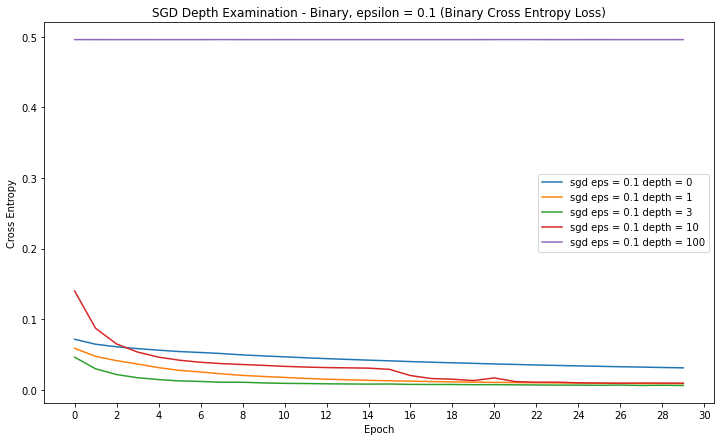

In [12]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Depth Examination - Binary, epsilon = 0.1 (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(layers)):
    plt.plot(bin_history[i][0].history['val_loss'],label='sgd eps = 0.1 depth = {}'.format(layers[i]))

plt.legend()
plt.show()

We immediately see that the 100-depth case has an almost constant loss at ~0.5 - much worse than each of the others, likely due to overfitting. It is difficult to see what is going on with the other cases, so we will plot them again with the 100-depth case removed.

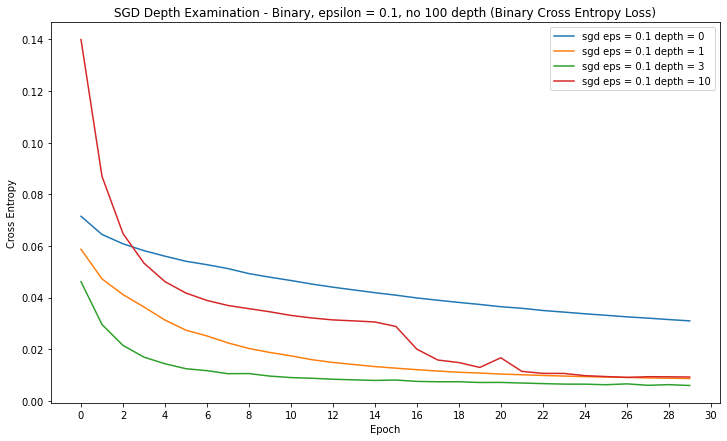

In [13]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Depth Examination - Binary, epsilon = 0.1, no 100 depth (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(layers) - 1):
    plt.plot(bin_history[i][0].history['val_loss'],label='sgd eps = 0.1 depth = {}'.format(layers[i]))

plt.legend()
plt.show()

We see that the zero-depth (perceptron) case converges more slowly than the others, and seems to be converging to a higher minimum. This is unsurprising, but it is reassuring to see that the hidden layers are actually doing something for us. Even a single hidden layer gives significantly faster convergence than the perceptron to a lower minimum, and going up to three hidden layers makes convergence even faster and the minimum even slower.

The interesting part is the 10-layer case - initially it seems to be converging to a higher minimum than even the shallow neural net (but still lower than the perceptron), though perhaps slightly faster. However, after about 16 epochs it escapes from this, and instead converges rapidly to approximately the same loss value as the shallow net. 

We now plot our chosen metric (AUC) for the same models, accross the 30 epochs:

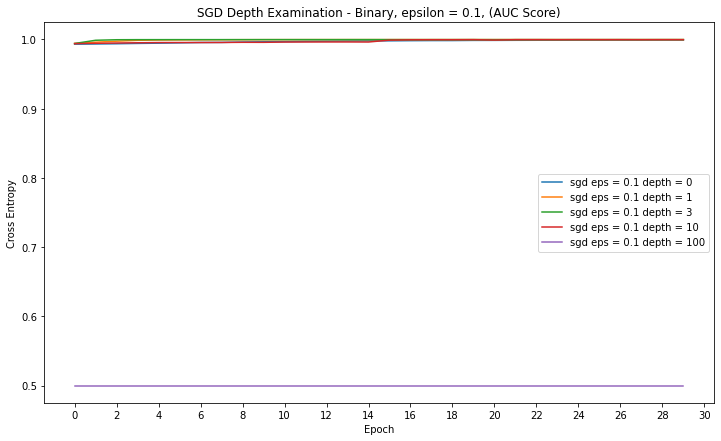

In [15]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Depth Examination - Binary, epsilon = 0.1, (AUC Score)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(layers)):
    plt.plot(bin_history[i][0].history['val_auc'],label='sgd eps = 0.1 depth = {}'.format(layers[i]))

plt.legend()
plt.show()

Again we see issues with the 100 depth network - the AUC is stuck at ~0.5 for the entire time, the same as we would expect for a random classifier! Similarly to the previous issue, this is probably due to overfitting. We plot again with this line removed so that we can discern the others:

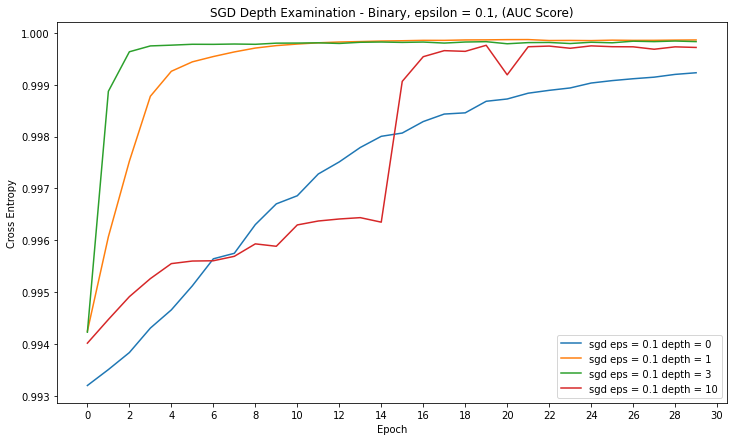

In [16]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Depth Examination - Binary, epsilon = 0.1, (AUC Score)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(layers) - 1):
    plt.plot(bin_history[i][0].history['val_auc'],label='sgd eps = 0.1 depth = {}'.format(layers[i]))

plt.legend()
plt.show()

There aren't really any surprises here - the AUC graph is largely reflective of the loss graph. The only thing worth mentioning is that the shallow network achieves a final AUC approximately as good as the 3-deep network does, despite having a noticably higher final loss. This is likely reflective of the fact that the cross-entropy and AUC are simply measuring different things, so getting the best score on one does not necessarily imply getting the best score on the other.

Finally, we can compare the confusion matrices for each of these models:
(Warning: getting predictions from each of these models will take quite a while! If you wish to run this yourself, I suggest commenting out the last line - the 100-layer model is the main culprit here, and its results are useless anyway)

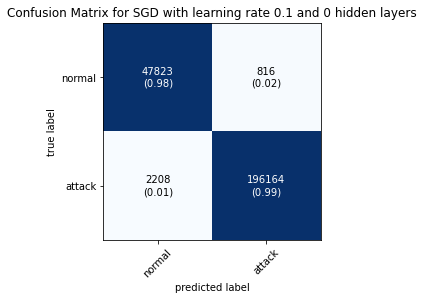

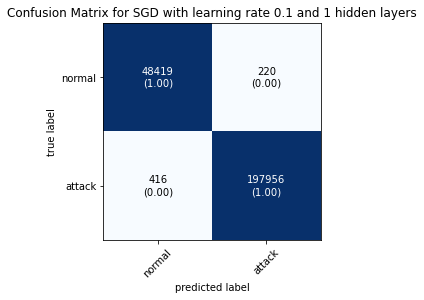

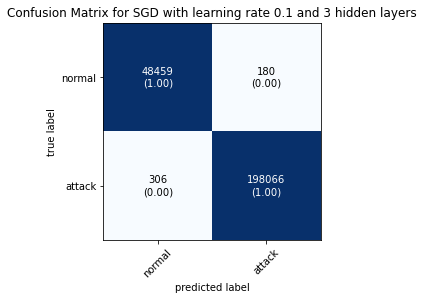

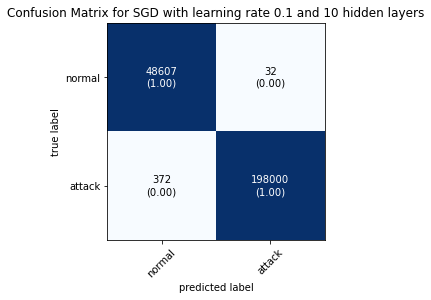

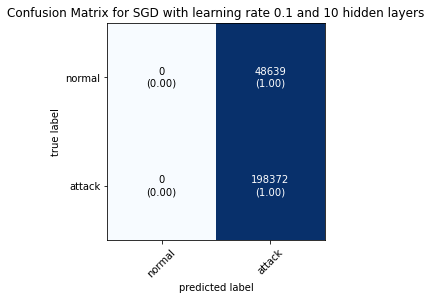

In [34]:
def plot_cmat_bin(model, i, j):
    pred = model.predict(X_test)
    pred = [round(x[0]) for x in pred]
    
    cmat = confusion_matrix(y_test_bin,pred)
    
    plot_confusion_matrix(conf_mat=cmat, show_normed=True, class_names=['normal','attack'])
    
    plt.title('Confusion Matrix for SGD with learning rate {} and {} hidden layers'.format(epsilons[j], layers[i]))
    
plot_cmat_bin(bin_models[0][0], 0, 0)
plot_cmat_bin(bin_models[1][0], 1, 0)
plot_cmat_bin(bin_models[2][0], 2, 0)
plot_cmat_bin(bin_models[3][0], 3, 0)
plot_cmat_bin(bin_models[4][0], 4, 0)

We can see from the confusion matrices that even the perceptron performs very well on this test data, though the shallow net is a significant improvement over it and the 3-layer net is a small improvement over that. The 10-layer net is a more dubious improvement - though it reduces the false positive rate, it simulaneously pushes up the false negative rate. Still, each of the 1/3/10-depth nets have near perfect performance. The 100-layer net has overfit catastrophically and predicted only a single class.

### Multiclass Classification

Again, we examine the loss functions over the 30 epochs:

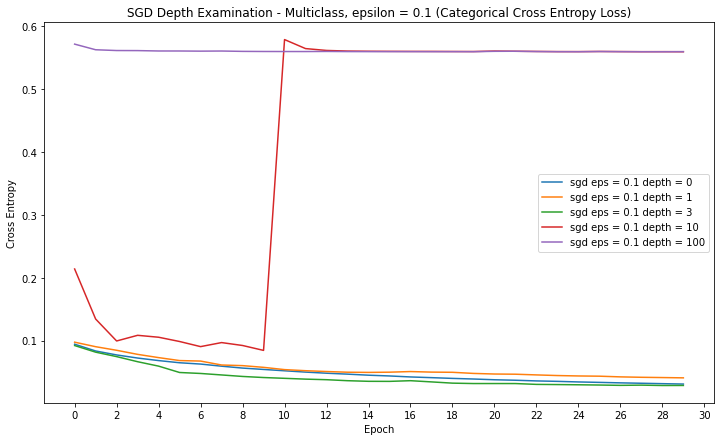

In [37]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Depth Examination - Multiclass, epsilon = 0.1 (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(layers)):
    plt.plot(categ_history[i][0].history['val_loss'],label='sgd eps = 0.1 depth = {}'.format(layers[i]))

plt.legend()
plt.show()

For the most part this is quite similar to the binary case. The main difference is in the behaviour of the 10-layer network. We again see that it starts off somewhere between the 1-layer and 100-layer cases, but this time it ends up converging to the same (very high) value as the 100-layer case. There is also some curious behaviour here with the perceptron - surprisingly, it actually performs *better* than the shallow net (but worse than the 3-layer net)

For greater interpretability, we will plot accuracy over the 30 epochs as well (note: we also have data for Cohen's Kappa, but it turns out that this produces effectively the same plot as accuracy):
The 10/100-layer networks are excluded for the sake of readability.

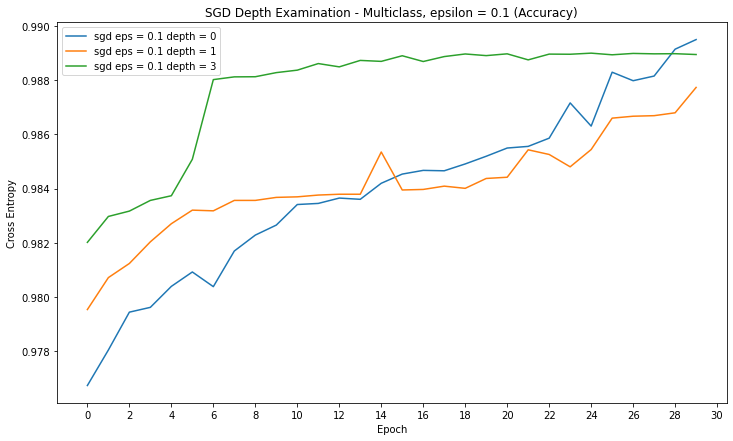

In [42]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Depth Examination - Multiclass, epsilon = 0.1 (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(layers)-2):
    plt.plot(categ_history[i][0].history['val_accuracy'],label='sgd eps = 0.1 depth = {}'.format(layers[i]))

plt.legend()
plt.show()

Interestingly, we see here that the perceptron actually ends up with the *best* accuracy after all 30 epochs, just beating the 3-depth network. I'm not sure why this is, and it could just be a fluke in this case. It does, however, converge much more slowly than the 3-depth network - and the difference in accuracy is very small anyway.

Ideally we would like to inspect confusion matrices at this point. However, the notebook has reached a point where it will run out of VRAM on my machine if I draw predictions from any more models - so this will unfortunately not be possible. You are invited to uncomment and run the below code if you wish to make such a comparison yourself.

In [ ]:
#def plot_cmat_categ(model, i, j):
#    pred = model.predict(X_test)
#    
#    cmat = confusion_matrix(tf.argmax(y_test_multi,axis=1),tf.argmax(pred,axis=1))
#    
#    plot_confusion_matrix(conf_mat=cmat, show_normed=True, class_names=categs)
#    
#    plt.title('Confusion Matrix for SGD with learning rate {} and {} hidden layers'.format(epsilons[j], layers[i]))
#    
#plot_cmat_bin(bin_models[0][0], 0, 0)
#plot_cmat_bin(bin_models[1][0], 1, 0)
#plot_cmat_bin(bin_models[2][0], 2, 0)
#plot_cmat_bin(bin_models[3][0], 3, 0)

Even without being able to compare multiclass confusion matrices, we can see that depth = 3 appears to be the best of the options which I have considered here at a learning rate of 0.1. In the binary case, it converges the fastest to the lowest loss, and it has the highest AUC score. We can also see from its confusion matrix that its classification on the test set is genuinely excellent here. In the multiclass case, it performed the best out of all of the networks with at least one hidden layer - but was outscored for accuracy by the perceptron. However, the perceptron is not suitable for our purposes going forward - and also it is not entirely clear whether it genuinely had a better classification. Moreover, the 3-depth network was much faster to converge.

We will therefore be using depth of 3 in subsequent sections. There will be some more examination here with different learning rates, but the focus was on 0.1 and this is sufficient to make our decision.

## $\varepsilon = 0.01$

We plot each of the same loss/metric graphs as in the 0.1 case.

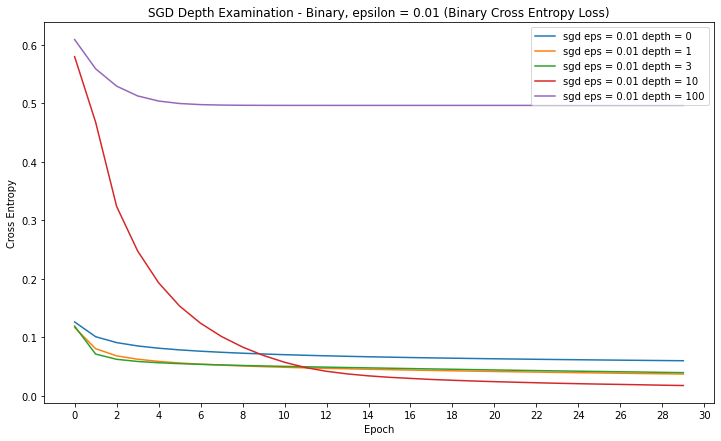

In [46]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Depth Examination - Binary, epsilon = 0.01 (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(layers)):
    plt.plot(bin_history[i][1].history['val_loss'],label='sgd eps = 0.01 depth = {}'.format(layers[i]))

plt.legend()
plt.show()

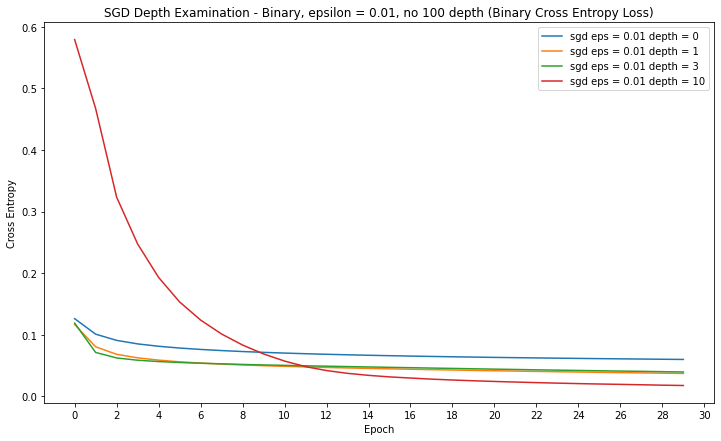

In [53]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Depth Examination - Binary, epsilon = 0.01, no 100 depth (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(layers) - 1):
    plt.plot(bin_history[i][1].history['val_loss'],label='sgd eps = 0.01 depth = {}'.format(layers[i]))

plt.legend()
plt.show()

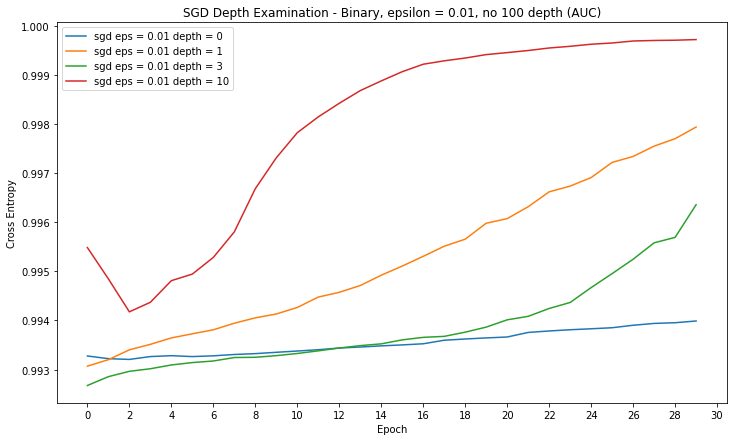

In [58]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Depth Examination - Binary, epsilon = 0.01, no 100 depth (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(layers) - 1):
    plt.plot(bin_history[i][1].history['val_auc'],label='sgd eps = 0.01 depth = {}'.format(layers[i]))

plt.legend()
plt.show()

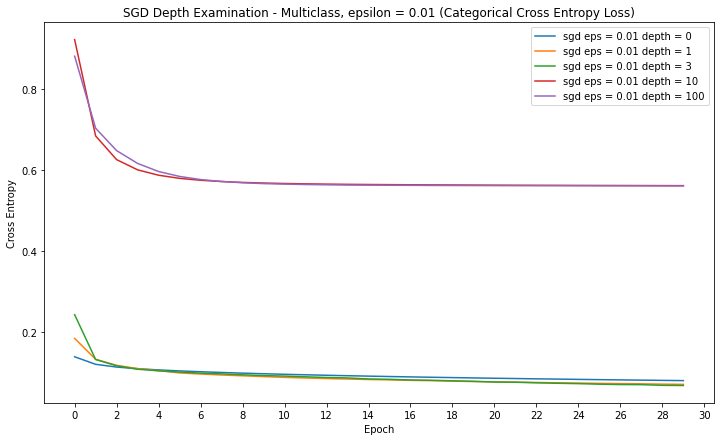

In [63]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Depth Examination - Multiclass, epsilon = 0.01 (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(layers)):
    plt.plot(categ_history[i][1].history['val_loss'],label='sgd eps = 0.01 depth = {}'.format(layers[i]))

plt.legend()
plt.show()

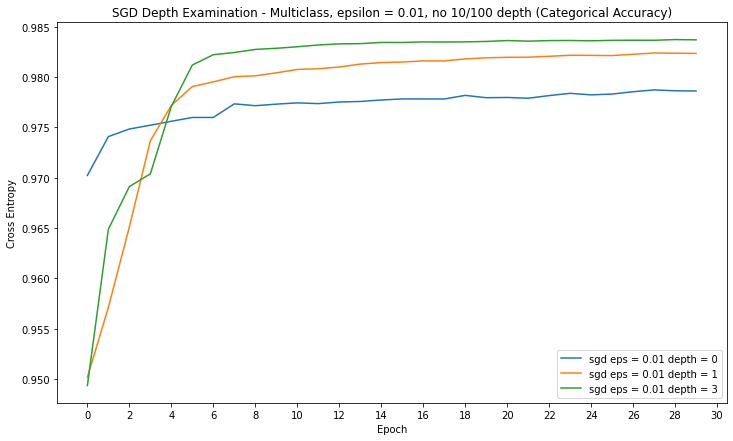

In [67]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Depth Examination - Multiclass, epsilon = 0.01, no 10/100 depth (Categorical Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(layers) - 2):
    plt.plot(categ_history[i][1].history['val_accuracy'],label='sgd eps = 0.01 depth = {}'.format(layers[i]))

plt.legend()
plt.show()

At this training rate, we see somewhat different results in the binary and multiclass cases. The multiclass case behaves similarly to the case of rate = 0.1, the main difference being that the 10-depth network converges to its overfit state much more quickly. In the binary class, however, we find that the 10-depth network significantly outperforms the other options *and* that it converges significantly faster than them.

## $\varepsilon = 0.001$

Again, we plot the same charts:

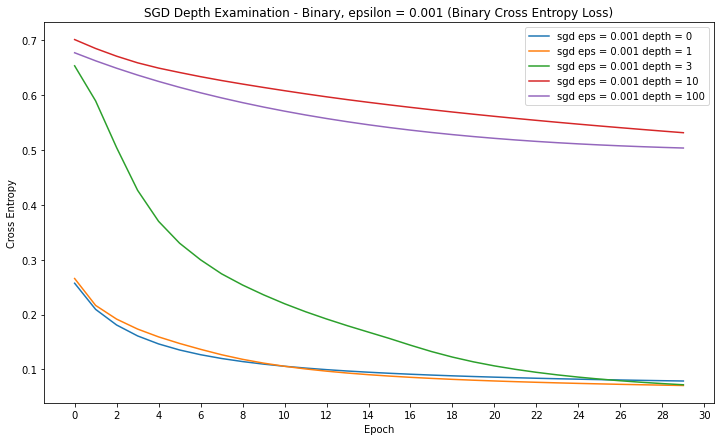

In [68]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Depth Examination - Binary, epsilon = 0.001 (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(layers)):
    plt.plot(bin_history[i][2].history['val_loss'],label='sgd eps = 0.001 depth = {}'.format(layers[i]))

plt.legend()
plt.show()

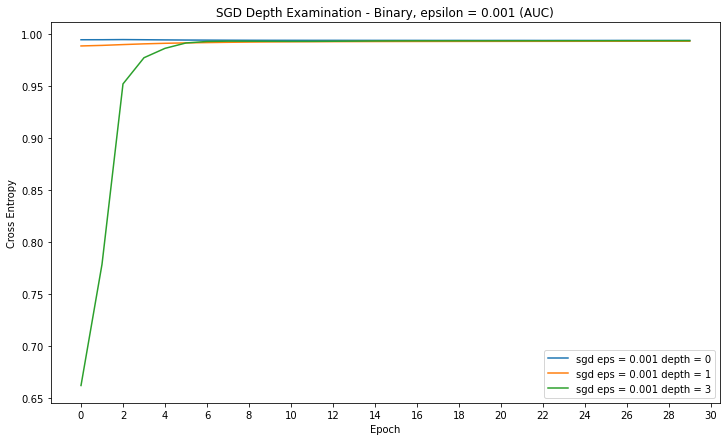

In [70]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Depth Examination - Binary, epsilon = 0.001 (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(layers) - 2):
    plt.plot(bin_history[i][2].history['val_auc'],label='sgd eps = 0.001 depth = {}'.format(layers[i]))

plt.legend()
plt.show()

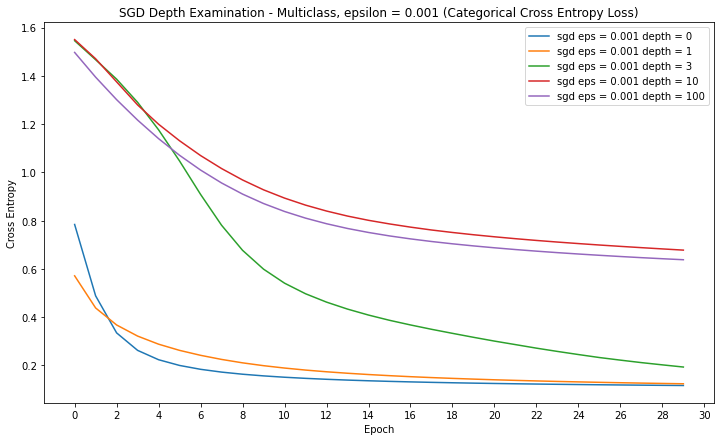

In [78]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Depth Examination - Multiclass, epsilon = 0.001 (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(layers)):
    plt.plot(categ_history[i][2].history['val_loss'],label='sgd eps = 0.001 depth = {}'.format(layers[i]))

plt.legend()
plt.show()

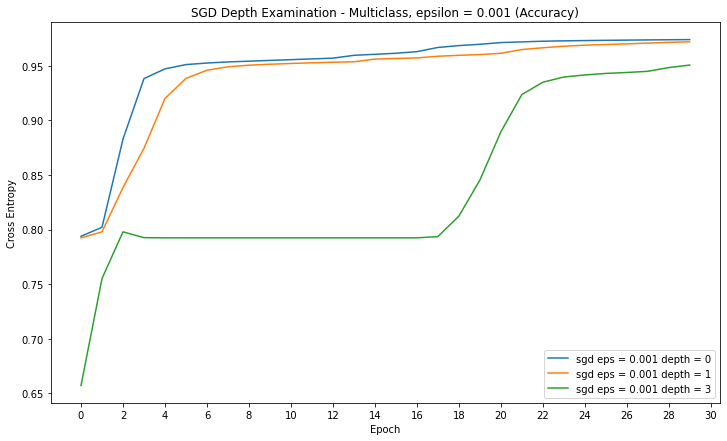

In [76]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Depth Examination - Multiclass, epsilon = 0.001 (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(layers)-2):
    plt.plot(categ_history[i][2].history['val_accuracy'],label='sgd eps = 0.001 depth = {}'.format(layers[i]))

plt.legend()
plt.show()

The binary case here is quite unsurprising - it's roughly the same pattern we've seen a few times by now. The interesting part is the multiclass case - specifically, the 3-depth net there. Looking at the accuracy graph, we see that it was stagnant at just under 80% for several epochs before it began to climb again (this probably indicates that it was classifying everything as DoS, which makes up just under 8% of the dataset). It would be tempting to speculate that it was stuck in a local minimum here, but this is not true! Examining the loss graph shows clearly that the loss was steadily falling throughout this time - a nice illustration of the fact that an improved loss does not necessarily imply an improved classification.

## $\varepsilon = 0.0001$

For the final time, we plot these charts:

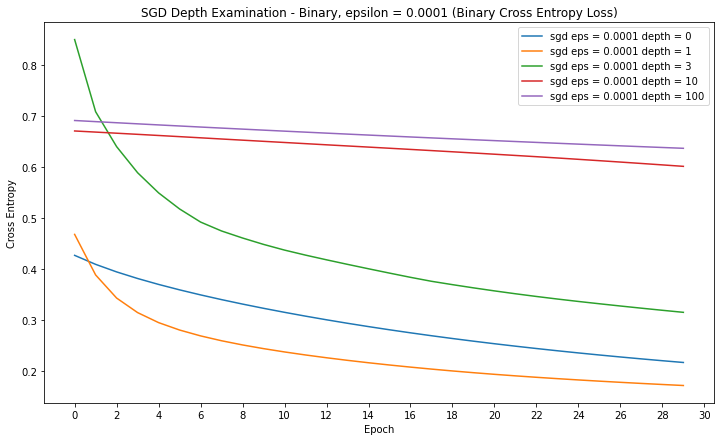

In [79]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Depth Examination - Binary, epsilon = 0.0001 (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(layers)):
    plt.plot(bin_history[i][3].history['val_loss'],label='sgd eps = 0.0001 depth = {}'.format(layers[i]))

plt.legend()
plt.show()

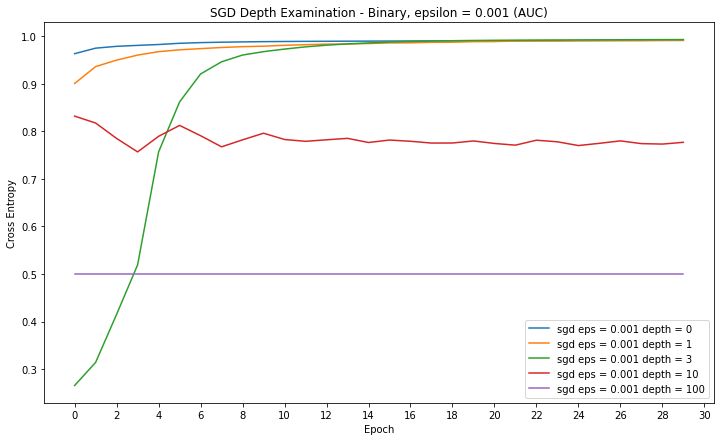

In [84]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Depth Examination - Binary, epsilon = 0.001 (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(layers)):
    plt.plot(bin_history[i][3].history['val_auc'],label='sgd eps = 0.001 depth = {}'.format(layers[i]))

plt.legend()
plt.show()

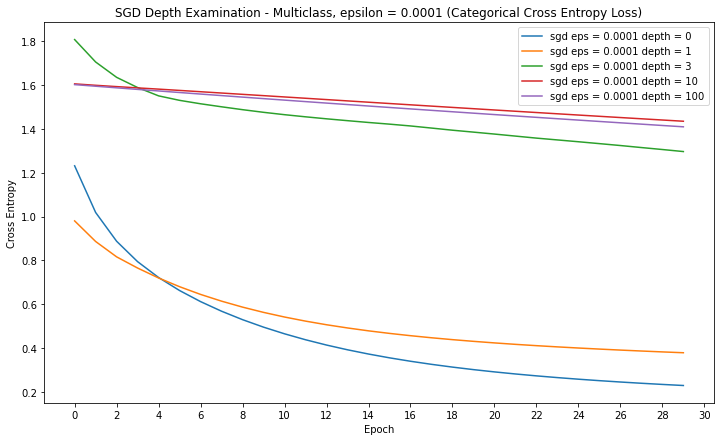

In [85]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Depth Examination - Multiclass, epsilon = 0.0001 (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(layers)):
    plt.plot(categ_history[i][3].history['val_loss'],label='sgd eps = 0.0001 depth = {}'.format(layers[i]))

plt.legend()
plt.show()

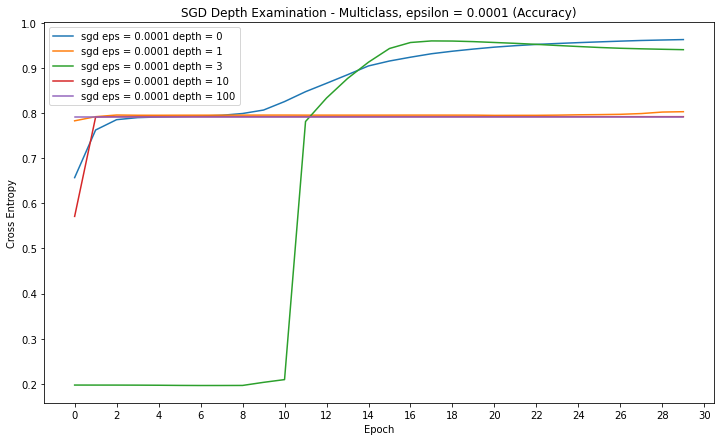

In [94]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Depth Examination - Multiclass, epsilon = 0.0001 (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(layers)):
    plt.plot(categ_history[i][3].history['val_accuracy'],label='sgd eps = 0.0001 depth = {}'.format(layers[i]))

plt.legend()
plt.show()

At this point, things have started to break down somewhat. In the binary case, we find that both the perceptron and the shallow net (which performs best of all) do better than even the 3-layer net with the 10 and 100-layer nets performing terribly as usual. Interestingly, unlike the other cases of overfitting that we've encountered, the 10-depth net's AUC score stabilises at ~0.8, rather than ~0.5. I would like to explore this by investigating the confusion matrix, but due to the afformentioned technical issues with VRAM I am unable to.

In the multiclass case, even stranger things happen. We find that the perceptron is the best performing, with the hidden layer in the shallow net actually hindering it - and all the other neural networks have overfitted catastrophically, even the one with depth = 3.